In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from astropy.io import fits

import matplotlib as mpl
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['image.origin'] = 'lower'

In [46]:
ZP = {
    'Y':28.13,
    'J':27.89,
    'H':27.54,
    'Ks':26.93,
    'J2':26.93,
    'J3':26.88,
    'H1':26.88,
    'H2':26.85
}

In [31]:
def r_theta(im, xc, yc):
    """r_theta - make a radius mask and return the radius rr and the angle phi for point (xc,yc)"""
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)
    
def get_cutout(path, prefix, obj_frame, sky_frame, cut_min=None, cut_max=None, sig_min=3.0, sig_max=3.0):
    sky_file = os.path.join(path, '{:s}{:04d}.fits'.format(prefix, sky_frame))
    obj_file = os.path.join(path, '{:s}{:04d}.fits'.format(prefix, obj_frame))

    obj = fits.getdata(obj_file)
    sky = fits.getdata(sky_file)
    diff = obj - sky

    # Get the sky level in the window
    ny, nx = diff.shape
    # define crude y, x boundaries
    x_coord, y_coord = np.meshgrid(np.arange(nx), np.arange(ny))
    upper_left_y, upper_left_x = (1070, 1034)
    upper_right_y, upper_right_x = (1070, 1051)
    lower_left_y, lower_left_x = (1035, 1037)
    lower_right_y, lower_right_x = (1032, 1055)

    median_box = (x_coord > lower_left_x) & (x_coord < upper_right_x) & (y_coord > lower_left_y) & (y_coord < upper_right_y)
    mean_sky, med_sky, sigma_sky = sigma_clipped_stats(diff[median_box], sigma_lower=3.0, sigma_upper=3.0)
    cut_min = med_sky - sig_min*sigma_sky if cut_min is None else cut_min
    cut_max = med_sky + sig_max*sigma_sky if cut_max is None else cut_max

    image = diff * median_box

    image_cutout = image[1035+1:1070,1037+1:1051]
    return image_cutout

In [45]:
path = "../resource"
qso_cutout = get_cutout(path, "qso_", 1, 0)
star_cutout = get_cutout(path, "star_", 1, 0)
qso_hdr =fits.getheader(f"{path}/qso_0001.fits")
star_hdr = fits.getheader(f"{path}/star_0001.fits")

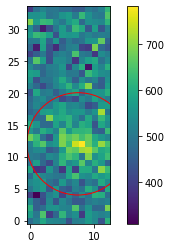

In [70]:
xcen = 7.5
ycen = 12

fig, ax = plt.subplots()
circle = mpl.patches.Circle((xcen,ycen), 8, fill=False, color="red")
ax.add_patch(circle)
a = ax.imshow(qso_cutout)
fig.colorbar(a)
plt.show()

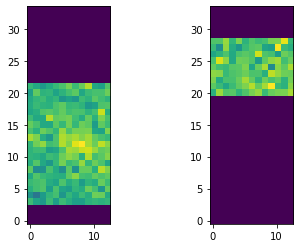

22.600508136073294


In [78]:
ly, lx = np.shape(qso_cutout)
Y, X = np.mgrid[0:ly, 0:lx]
mask = (Y < ycen + 10) & (Y > ycen - 10)
size = len(qso_cutout[mask])
mask_bg = (Y < (ycen+12) + 5) & (Y > (ycen+12) - 5)
size_bg = len(qso_cutout[mask_bg])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(qso_cutout*mask)
axs[1].imshow(qso_cutout*mask_bg)
plt.show()

f_qso = (np.sum(qso_cutout[mask]) - np.sum(qso_cutout[mask_bg])*size/size_bg) / qso_hdr["ELAPTIME"]
m_qso = -2.5 * np.log10(f_qso) + ZP["J"]

print(m_qso)

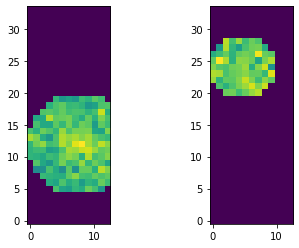

22.422844587228433


In [79]:
m = np.ones_like(qso_cutout)
rr, phi = r_theta(m, xcen, ycen)
mask = (rr <= 8)
rr, phi = r_theta(m, xcen-3, ycen+12)
mask_bg = (rr <= 5)
size = len(qso_cutout[mask])
size_bg = len(qso_cutout[mask_bg])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(qso_cutout*mask)
axs[1].imshow(qso_cutout*mask_bg)
plt.show()

f_qso = (np.sum(qso_cutout[mask]) - np.sum(qso_cutout[mask_bg])*size/size_bg) / qso_hdr["ELAPTIME"]
m_qso = -2.5 * np.log10(f_qso) + ZP["J"]

print(m_qso)

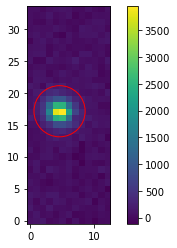

In [68]:
xcen = 4.6
ycen = 17.1

fig, ax = plt.subplots()
circle = mpl.patches.Circle((xcen,ycen), 4, fill=False, color="red")
ax.add_patch(circle)
a = ax.imshow(star_cutout)
fig.colorbar(a)
plt.show()

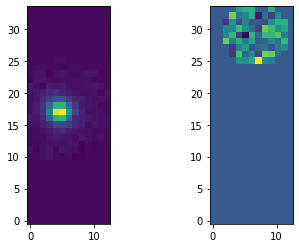

19.303552588580757


In [82]:
xcen = 4.6
ycen = 17.1

m = np.ones_like(star_cutout)
rr, phi = r_theta(m, xcen, ycen)
mask = (rr <= 8)
rr, phi = r_theta(m, xcen+2, ycen+12)
mask_bg = (rr <= 5)
size = len(star_cutout[mask])
size_bg = len(star_cutout[mask_bg])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(star_cutout*mask)
axs[1].imshow(star_cutout*mask_bg)
plt.show()

f_star = (np.sum(star_cutout[mask]) - np.sum(star_cutout[mask_bg])) / star_hdr["ELAPTIME"]
m_star = -2.5 * np.log10(f_star) + ZP["J"]

print(m_star)

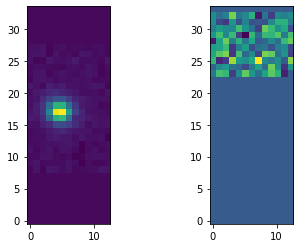

19.428873225213692


In [83]:
xcen = 4.6
ycen = 17.1

ly, lx = np.shape(star_cutout)
Y, X = np.mgrid[0:ly, 0:lx]
mask = (Y < ycen + 10) & (Y > ycen - 10)
size = len(star_cutout[mask])
mask_bg = (Y < (ycen+10) + 5) & (Y > (ycen+10) - 5)
size_bg = len(star_cutout[mask_bg])

fig, axs = plt.subplots(1, 2)
axs[0].imshow(star_cutout*mask)
axs[1].imshow(star_cutout*mask_bg)
plt.show()

f_star = (np.sum(star_cutout[mask]) - np.sum(star_cutout[mask_bg])*size/size_bg) / star_hdr["ELAPTIME"]
m_star = -2.5 * np.log10(f_star) + ZP["J"]

print(m_star)

In [91]:
qso_mjd = qso_hdr["MJD-obs"]
star_mjd = star_hdr["MJD-obs"]

In [95]:
from highz_qso_arxiv.util import *
from highz_qso_arxiv.crawler import get_skyprobe_extinction

In [98]:
qso_unix = mjd_to_unix(qso_mjd)

In [97]:
star_unix = mjd_to_unix(star_mjd)

In [99]:
get_skyprobe_extinction(star_unix-300, star_unix+300)

time,extinction,scatter
UNIX,mag,mag
int64,float64,float64
1590664144,1.15,0.011
1590664204,1.074,0.008
1590664265,1.012,0.008
1590664326,0.903,0.01
1590664384,0.887,0.009
1590664444,0.857,0.007
1590664505,0.852,0.007
1590664565,0.933,0.01


In [102]:
qso_unix, star_unix

(1590664601.585664, 1590664413.395232)

In [100]:
get_skyprobe_extinction(qso_unix-300, qso_unix+300)

time,extinction,scatter
UNIX,mag,mag
int64,float64,float64
1590664326,0.903,0.01
1590664384,0.887,0.009
1590664444,0.857,0.007
1590664505,0.852,0.007
1590664565,0.933,0.01
1590664625,0.909,0.009
1590664685,0.907,0.01
1590664745,0.952,0.012


In [101]:
print(get_skyprobe_extinction.__doc__)

get extinction data from SkyProbe
       link: https://www.cfht.hawaii.edu/Instruments/Elixir/skyprobe/archive-new.html

        NOTE: there is a small, but variable, zero-point offset to the extinction measurement. 
              This varies based on sky conditions, instrument cleanliness (dust on the lens), 
              and telescope airmass. 
              For simplicity's sake, CFHT staff usually assume an average offset of +0.03.
              Thus we probably should -0.03 from the extinction we get.
    Args:
        t_start (int): UNIX time
        t_end (int):UNIX time
    
